In [ ]:
""" 
Goal: Analyze the most interesting edges, TFs and genes in both regression analyses 
"""

In [1]:
import pandas as pd
from scipy.stats import rankdata
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from random import sample
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import pearsonr

In [2]:
# Load data

rna = pd.read_csv("../data/RNAseqData_LTRC_subset.txt", sep = "\t")
p2l_merged = pd.read_feather("../data/p2l_merged.feather")
l2p_merged = pd.read_feather("../data/l2p_merged.feather")
expr = pd.read_csv("../data/final_expr.txt", sep="\t")
panda_net = pd.read_feather("../data/panda_network.feather")

In [3]:
all_merged = pd.read_feather("../data/2025-12-05-08:58:37_regression_all_merged_gender_age_pckyr_race.feather")
all_merged = all_merged.drop(columns=["l2p_rank", "p2l_rank", "rank_diff", "abs_rank_diff"])
all_merged["z_score_combined"] = (all_merged["z_score_l2p"] + all_merged["z_score_p2l"]) / np.sqrt(2)

In [4]:
motif = pd.read_csv('../data/motif.txt', sep="\t", header=None)

motif["TF"] = motif[0]
motif["Gene"] = motif[1]
motif["Score"] = motif[2]
motif = motif.drop(columns=[0,1,2])

tot_combs = len(motif['TF'].unique()) * len(motif['Gene'].unique())
real_combs = len(motif["TF"])
real_combs/tot_combs

0.049438613619721745

(array([1.0000e+00, 1.0000e+00, 5.0000e+00, 5.0000e+00, 3.0000e+00,
        6.0000e+00, 1.7000e+01, 4.0000e+01, 6.9000e+01, 1.2500e+02,
        1.5200e+02, 2.6500e+02, 4.2700e+02, 8.7900e+02, 1.1730e+03,
        1.9960e+03, 3.4160e+03, 5.5840e+03, 9.1250e+03, 1.3802e+04,
        2.0805e+04, 2.9270e+04, 3.8953e+04, 4.4686e+04, 4.2989e+04,
        3.5607e+04, 2.6819e+04, 1.8401e+04, 1.1999e+04, 7.6170e+03,
        4.7900e+03, 2.8080e+03, 1.7730e+03, 1.0710e+03, 7.1600e+02,
        3.7200e+02, 2.4400e+02, 1.8000e+02, 9.2000e+01, 6.1000e+01,
        4.4000e+01, 2.5000e+01, 8.0000e+00, 1.5000e+01, 8.0000e+00,
        7.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-9.17011402, -8.78549876, -8.4008835 , -8.01626824, -7.63165298,
        -7.24703772, -6.86242246, -6.4778072 , -6.09319195, -5.70857669,
        -5.32396143, -4.93934617, -4.55473091, -4.17011565, -3.78550039,
        -3.40088513, -3.01626987, -2.63165462, -2.24703936, -1.8624241 ,
        -1.47780884, -1.09

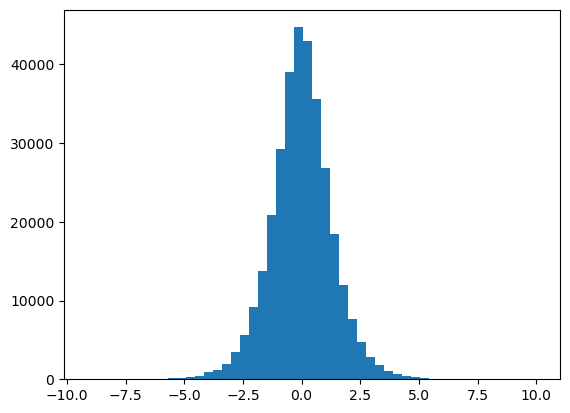

In [5]:
plt.hist(all_merged["z_score_combined"], bins=50)

In [6]:
highest_zscores = all_merged[abs(all_merged["z_score_combined"]) > 5].sort_values("z_score_combined")

In [10]:
real_edges = []

for idx, edge in highest_zscores.iterrows():
    tf = edge['TF']
    gene = edge['Gene']
    
    tf_df = motif[motif['TF'] == tf]
    
    if gene in list(tf_df['Gene']):
        real_edges.append(idx)
    
print(f"Number of total edges of interest: {highest_zscores.shape[0]}")
print(f"Number of edges of interest that actually exist in motif: {len(real_edges)}")

Number of total edges of interest: 862
Number of edges of interest that actually exist in motif: 22


In [19]:
all_merged.columns

Index(['beta_score_l2p', 'p_value_l2p', 'beta_score_p2l', 'p_value_p2l',
       'beta_score_diff', 'p_value_diff', 'TF', 'Gene', 'z_score_l2p',
       'z_score_p2l', 'z_score_diff', 'z_score_combined'],
      dtype='object')

In [11]:
all_merged_for_analysis = all_merged[["Gene", "z_score_combined"]]

In [12]:
all_merged_for_analysis

,Gene,z_score_combined
edge,,
ALX1_MIR1-1,MIR1-1,1.472976
ALX3_MIR1-1,MIR1-1,-1.082258
ALX4_MIR1-1,MIR1-1,1.372850
ARGFX_MIR1-1,MIR1-1,0.205965
ARID3A_MIR1-1,MIR1-1,0.087195
...,...,...
ZSCAN4_MIR99B,MIR99B,-1.495554
ZSCAN5_MIR99B,MIR99B,-0.431781
ZSCAN5C_MIR99B,MIR99B,1.073013


In [18]:
top_20_tf = highest_zscores.value_counts("TF").head(20)
top_20_tf

TF
DPRX       50
SREBF1     32
ALX3       26
NOTO       26
KLF1       25
ZNF410     23
FOXB1      22
ISX        16
LBX1       16
PRRX2      16
SHOX       16
LHX8       16
RAX2       16
SHOX2      16
PRRX1      16
HESX1      16
DLX6       16
NANOGP8    15
ZNF891     14
NR5A2      13
Name: count, dtype: int64

In [41]:
top_gene = highest_zscores.value_counts("Gene")

top_gene_df = pd.DataFrame(columns=["Positive Z-Score", "Negative Z-Score", "PANDA Degree"])

for gene in top_gene.index:
    pos = sum(highest_zscores[highest_zscores["Gene"] == gene]["z_score_combined"] > 0)
    neg = sum(highest_zscores[highest_zscores["Gene"] == gene]["z_score_combined"] < 0)
    deg = sum(panda_net[gene] > 2)
    top_gene_df.loc[gene] = [pos, neg, deg]



Text(0.5, 0, 'Degree')

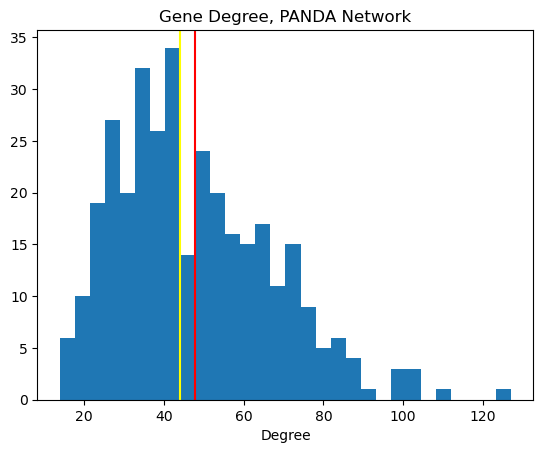

In [35]:
degrees = []
for col in panda_net:
    degrees.append(sum(panda_net[col] > 2))
    
plt.hist(degrees, bins=30)
plt.axvline(np.median(degrees), color="yellow")
plt.axvline(np.mean(degrees), color="red")
plt.title("Gene Degree, PANDA Network")
plt.xlabel("Degree")

Text(0.5, 0, 'Degree')

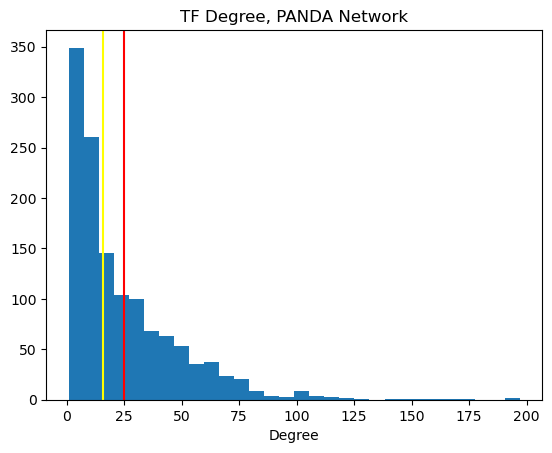

In [36]:
degrees_tf = []
for tf in panda_net.index:
    degrees.append(sum(panda_net.loc[tf] > 2))
    
plt.hist(degrees, bins=30)
plt.axvline(np.median(degrees), color="yellow")
plt.axvline(np.mean(degrees), color="red")
plt.title("TF Degree, PANDA Network")
plt.xlabel("Degree")

In [24]:
tf_df = pd.DataFrame(columns=["Positive Z-Score", "Negative Z-Score", "PANDA Degree"])
for tf in top_20_tf.index:
    pos = sum(highest_zscores[highest_zscores["TF"] == tf]["z_score_combined"] > 0)
    neg = sum(highest_zscores[highest_zscores["TF"] == tf]["z_score_combined"] < 0)
    deg = sum(panda_net.loc[tf] > 2)
    tf_df.loc[tf] = [pos, neg, deg]
    
tf_df

,Positive Z-Score,Negative Z-Score,PANDA Degree
DPRX,29,21,3
SREBF1,19,13,4
ALX3,17,9,7
NOTO,17,9,7
KLF1,15,10,2
ZNF410,16,7,7
FOXB1,19,3,7
ISX,7,9,10
LBX1,7,9,10
PRRX2,7,9,10


In [26]:
highest_zscores.sort_values("z_score_combined").tail(20)[[ "beta_score_l2p", "beta_score_p2l", "z_score_combined"]]

,beta_score_l2p,beta_score_p2l,z_score_combined
edge,,,
CENPBD1_MIR20B,0.527121,0.150900,7.761156
SREBF1_MIR941-3,0.567855,0.142840,7.851880
NOTO_MIR203A,0.516956,0.157613,7.859491
ALX3_MIR203A,0.516956,0.157613,7.859491
ZNF562_MIR941-3,0.393921,0.195693,7.938924
DPRX_MIR139,0.526882,0.161309,8.027241
KLF1_MIR15A,0.479664,0.176526,8.073253
DPRX_MIR10B,0.517315,0.168857,8.151454
DPRX_MIR330,0.478159,0.183182,8.233509


In [27]:
highest_zscores.sort_values("z_score_combined").head(20)[["beta_score_l2p", "beta_score_p2l", "z_score_combined"]]

,beta_score_l2p,beta_score_p2l,z_score_combined
edge,,,
DPRX_MIR449B,-0.623896,-0.179697,-9.170114
FOXN2_MIR144,-0.475204,-0.200010,-8.604554
KLF1_MIR144,-0.484475,-0.189356,-8.398264
DPRX_MIR664B,-0.360058,-0.223973,-8.378476
HESX1_MIR4677,-0.579490,-0.159524,-8.326012
KMT2A_MIR664B,-0.459727,-0.183614,-8.069384
HINFP_MIR664B,-0.459727,-0.183614,-8.069384
DPRX_MIR326,-0.298966,-0.224472,-7.944182
ZNF32_MIR18B,-0.436395,-0.182524,-7.870565


(array([ 1.,  0.,  0.,  1.,  4.,  2.,  2.,  2.,  0.,  2.,  4., 10., 10.,
         8.,  9.,  7.,  8.,  8., 15., 15., 13., 11.,  9., 15., 17., 12.,
         7., 20., 18., 11., 15., 11., 12.,  9.,  5.,  9., 10.,  9.,  4.,
         2.,  1.,  0.,  4.,  1.,  1.,  1.,  2.,  1.,  0.,  1.]),
 array([-3.76362491, -3.59314769, -3.42267047, -3.25219325, -3.08171603,
        -2.91123881, -2.74076159, -2.57028437, -2.39980716, -2.22932994,
        -2.05885272, -1.8883755 , -1.71789828, -1.54742106, -1.37694384,
        -1.20646662, -1.0359894 , -0.86551218, -0.69503496, -0.52455774,
        -0.35408052, -0.18360331, -0.01312609,  0.15735113,  0.32782835,
         0.49830557,  0.66878279,  0.83926001,  1.00973723,  1.18021445,
         1.35069167,  1.52116889,  1.69164611,  1.86212332,  2.03260054,
         2.20307776,  2.37355498,  2.5440322 ,  2.71450942,  2.88498664,
         3.05546386,  3.22594108,  3.3964183 ,  3.56689552,  3.73737274,
         3.90784995,  4.07832717,  4.24880439,  4.41928161,

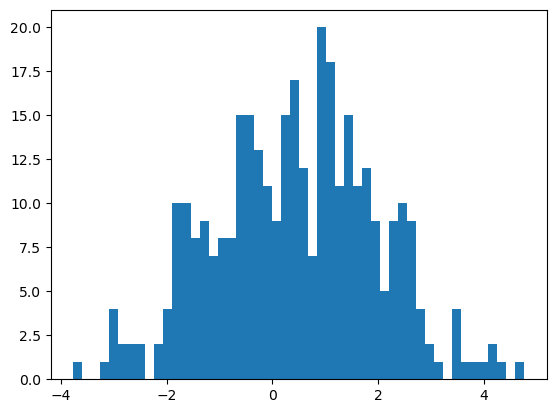

In [28]:
plt.hist(all_merged[all_merged["TF"] == "ZNF552"]["z_score_combined"], bins=50)

In [31]:
real_edges = highest_zscores[highest_zscores.index.isin(real_edges)][["beta_score_l2p", "beta_score_p2l", "z_score_combined"]]

In [32]:
tf_df

,Positive Z-Score,Negative Z-Score,PANDA Degree
DPRX,29,21,3
SREBF1,19,13,4
ALX3,17,9,7
NOTO,17,9,7
KLF1,15,10,2
ZNF410,16,7,7
FOXB1,19,3,7
ISX,7,9,10
LBX1,7,9,10
PRRX2,7,9,10


In [33]:
for index in tf_df.index:
    temp_df = rna[rna["Gene_Symbol"] == index]
    temp_df = temp_df.drop(columns=["Gene_Symbol", "ENSG"])
    mean_val = np.mean(temp_df.values)  # or temp_df.to_numpy()
    tf_df.at[index, "rnaseq"] = mean_val
    
tf_df

/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/glass/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid valu

,Positive Z-Score,Negative Z-Score,PANDA Degree,rnaseq
DPRX,29,21,3,NaN
SREBF1,19,13,4,NaN
ALX3,17,9,7,NaN
NOTO,17,9,7,NaN
KLF1,15,10,2,NaN
ZNF410,16,7,7,NaN
FOXB1,19,3,7,NaN
ISX,7,9,10,NaN
LBX1,7,9,10,NaN
PRRX2,7,9,10,1.757277


In [34]:
for index in gene_df.index:
    temp_df = rna[rna["Gene_Symbol"] == index]
    temp_df = temp_df.drop(columns=["Gene_Symbol", "ENSG"])
    mean_val = np.mean(temp_df.values)  # or temp_df.to_numpy()
    gene_df.at[index, "rnaseq"] = mean_val
    
gene_df

NameError: name 'gene_df' is not defined

In [ ]:
# for index in gene_df.index:
#     print(index)
#     print(np.mean(expr.loc[index]))
    



MIR941-3
7.234791628276101
MIR15A
8.579758587452202
MIR664B
2.1069823882527943
MIR139
8.699225992244013
MIR449B
3.288872075222261
MIR106A
2.728223722769321
MIR10B
15.020788532340003
MIR1270
1.0519424297379965
MIR18B
1.3544667634052618
MIR186
12.243955583965299
MIR144
16.867104320590176
MIR335
15.254819441684154
MIR1277
2.1763535461516232
MIR4510
1.9923495094141803
MIR128-1
5.649850778182656
MIR449A
5.292601712271867
MIR15B
12.268765338301781
MIR1226
0.8946589727875534
MIR625
4.665293590151372
MIR532
11.267809112207313


In [37]:
np.mean(expr.loc["MIR532"])

np.float64(11.267809112207313)

In [38]:
expr

,LT187987LL,LT166493RM,LT109321RL,LT104717LL,LT185066RL,LT291578RU,LT075094LU,LT051568RU,LT194990RU,LT132314LI,...,LT211455LU,LT174536LU,LT203541RU,LT195192RL,LT056464LL,LT271679LU,LT212777RU,LT299181LU,LT145196LU,LT167906LL
MIR15A,9.132968,8.679005,7.876751,9.057266,9.113764,9.761880,9.220851,9.104805,9.071265,9.713545,...,8.045882,8.099648,8.526389,7.745373,7.440123,6.977682,8.208773,8.158180,8.220226,7.808646
MIR16-1,12.891717,12.339001,12.077981,11.954619,11.669142,14.064280,13.346444,12.824774,11.643907,12.453548,...,12.729988,13.266475,12.448563,12.187535,12.834773,11.988119,13.661252,13.638103,13.161343,13.323901
MIR17,12.805241,12.766182,12.158283,12.464601,12.769388,13.641708,14.572626,14.196931,12.991849,13.359054,...,10.807514,11.112607,10.696812,10.065449,9.877774,9.524549,11.956913,11.626915,12.467287,10.142540
MIR18A,6.213305,5.850240,4.439106,5.526013,5.599244,7.113753,6.371074,7.114879,6.214468,7.247880,...,5.292649,5.313488,4.010424,3.762559,3.286217,3.068136,4.971829,4.963042,4.956791,2.806220
MIR19A,4.824245,4.350890,4.086025,4.841415,4.901329,5.503894,5.477987,5.551206,4.561111,4.728357,...,6.098588,8.585144,5.850551,6.775255,6.008686,6.203975,6.817243,8.296391,8.865084,4.089972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MIR5100,2.025297,0.639683,0.163129,0.442981,0.253505,0.856474,0.590379,0.608196,0.351276,0.895846,...,1.416983,1.342232,0.595341,0.363310,1.381915,0.811881,0.381196,0.777014,1.416714,1.784585
MIR664B,4.335244,4.048544,4.500448,3.400276,2.495583,4.540618,5.080015,3.509736,3.342999,4.298906,...,0.778905,0.000000,0.328164,1.789240,2.701625,1.274195,1.143840,1.975567,1.416714,2.632966
MIR548AW,1.941275,1.385134,0.780962,1.212779,1.189456,1.880193,1.711667,3.698794,2.083841,1.067251,...,1.281939,1.723842,1.187181,1.442673,0.000000,0.811881,0.000000,0.777014,1.416714,0.000000
MIR5683,3.731512,2.575284,2.956756,1.712052,2.092783,2.319238,3.530481,3.309464,1.207594,1.840806,...,1.416983,3.239533,1.015540,1.587180,2.992759,2.007912,1.328897,1.279270,0.000000,0.626090


In [42]:
expr_list = []
for index in expr.index:
    mean_val = np.mean(expr.loc[index])
    expr_list.append(mean_val)
    

Text(0.5, 1.0, 'Average miRNA Expression, per miRNA')

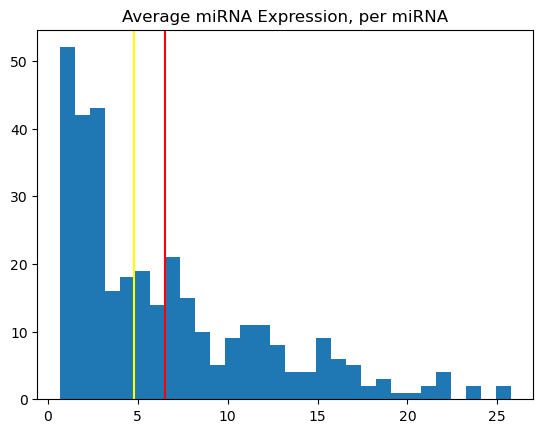

In [43]:
plt.hist(expr_list, bins=30)
plt.axvline(np.median(expr_list), color="yellow")
plt.axvline(np.mean(expr_list), color="red")
plt.title("Average miRNA Expression, per miRNA")

In [ ]:
# gene_df = gene_df["expr"]

In [44]:
expr_regr = pd.read_csv("../data/expr_regr_fev1fvc.csv", index_col=0)

In [45]:
# # Do I define based on degree
pos_df = top_gene_df[top_gene_df["Positive Z-Score"] > top_gene_df["Negative Z-Score"]]
neg_df = top_gene_df[top_gene_df["Positive Z-Score"] < top_gene_df["Negative Z-Score"]]

pos_df = pos_df[pos_df["Positive Z-Score"] > 5]
pos_set = pos_df.index

neg_df = neg_df[neg_df["Negative Z-Score"] > 5]
neg_set = neg_df.index

In [48]:
pos_df

,Positive Z-Score,Negative Z-Score,PANDA Degree
MIR941-3,43,8,31
MIR10B,26,1,45
MIR15A,20,3,99
MIR139,18,4,43
MIR93,18,0,30
MIR26B,16,1,34
MIR1180,13,1,21
MIR182,14,0,29
MIR532,12,0,77
MIR15B,7,5,63


In [50]:
neg_df

,Positive Z-Score,Negative Z-Score,PANDA Degree
MIR4510,12,28,93
MIR664B,6,27,59
MIR449B,5,23,58
MIR449A,4,18,57
MIR1270,8,11,67
MIR20B,7,11,51
MIR128-2,0,17,42
MIR509-2,0,14,50
MIR4516,0,14,74
MIR491,3,10,98


In [51]:
pos_est = list()
other_est = list()
for i in expr_regr.iterrows():
    if i[0] in pos_set:
        pos_est.append(i[1]["Estimate"])
    else:
        other_est.append(i[1]["Estimate"])

stats.ttest_ind(pos_est, other_est)

TtestResult(statistic=np.float64(-0.8289257452908999), pvalue=np.float64(0.4077314049062797), df=np.float64(338.0))

In [54]:
neg_est = list()
other_est = list()
for i in expr_regr.iterrows():
    if i[0] in neg_set:
        neg_est.append(i[1]["Estimate"])
    else:
        other_est.append(i[1]["Estimate"])

stats.ttest_ind(neg_est, other_est)

TtestResult(statistic=np.float64(-1.2759473598451452), pvalue=np.float64(0.20285024496391127), df=np.float64(338.0))

In [53]:
expr_regr

,Estimate,Std. Error,t value,Pr(>|t|)
MIR15A,-0.229286,0.195734,-1.171417,2.427977e-01
MIR16-1,-0.519207,0.229160,-2.265698,2.451990e-02
MIR17,-0.206459,0.376339,-0.548599,5.838809e-01
MIR18A,-0.446360,0.426173,-1.047369,2.961689e-01
MIR19A,-0.465435,0.363504,-1.280411,2.018545e-01
...,...,...,...,...
MIR664B,0.037036,0.281977,0.131345,8.956320e-01
MIR548AW,-0.181090,0.198784,-0.910989,3.633765e-01
MIR5683,0.185889,0.349144,0.532414,5.950189e-01
MIR5690,-0.286536,0.149043,-1.922500,5.593569e-02
